In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from fast_hdbscan.numba_kdtree import kdtree_to_numba
from fast_hdbscan.numba_kdtree import parallel_tree_query
from sklearn.neighbors import KDTree

CPU times: user 11.2 s, sys: 435 ms, total: 11.6 s
Wall time: 9.26 s


In [2]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"

In [3]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [4]:
graph.cardinalities.describe()

count    304554.000000
mean          6.751085
std           2.060782
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          82.000000
Name: cardinalities, dtype: float64

In [5]:
from core.cluster_validation import print_distance, generate_neigbhourhood_groups

In [6]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [7]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')



X_train = X_train[X_train.index >= 0]



spatial_lag = 3


# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')



# X_train = X_train.join(lag[[c for c in lag.columns if '_median' in c]], how='inner')
X_train = X_train.join(lag, how='inner')


In [8]:
vals = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

vals = np.nan_to_num(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)


# X_train = X_train.clip(-10, 10)

In [9]:
X_train.shape

(299064, 248)

In [10]:
tess_groups = generate_neigbhourhood_groups(tessellation, 
                                         include_random_sample=True,
                                         random_sample_size=1_000)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [11]:
# tessellation.loc[tess_groups.index].explore()

In [12]:
from core.cluster_validation import print_distance
print_distance( pd.DataFrame(X_train.loc[tess_groups.index]).groupby(tess_groups.values).mean(), metric='sqeuclidean')

,holyne,housing estate,josefov,karlin,mala strana,malesice,nusle,random,stare mesto,vinohrady
holyne,0.000000,104.049453,461.013514,456.767054,779.024517,496.183067,148.985827,48.718056,758.131087,482.364005
housing estate,104.049453,0.000000,307.741319,298.064276,755.867743,473.573734,56.576285,40.119697,634.561400,295.044087
josefov,461.013514,307.741319,0.000000,197.265970,425.769345,859.154292,189.511414,382.883530,166.927295,167.663552
karlin,456.767054,298.064276,197.265970,0.000000,495.149852,617.761042,239.237763,330.149432,294.199349,100.278084
mala strana,779.024517,755.867743,425.769345,495.149852,0.000000,1124.441104,621.477656,754.878358,176.810827,696.270181
malesice,496.183067,473.573734,859.154292,617.761042,1124.441104,0.000000,514.949155,348.382329,1097.666442,782.540852
nusle,148.985827,56.576285,189.511414,239.237763,621.477656,514.949155,0.000000,93.555314,488.944932,221.731384
random,48.718056,40.119697,382.883530,330.149432,754.878358,348.382329,93.555314,0.000000,684.315028,362.995575
stare mesto,758.131087,634.561400,166.927295,294.199349,176.810827,1097.666442,488.944932,684.315028,0.000000,406.986590
vinohrady,482.364005,295.044087,167.663552,100.278084,696.270181,782.540852,221.731384,362.995575,406.986590,0.000000


In [20]:
training_data = X_train.loc[tess_groups.index]
tess_groups_ilocs = (
    pd.Series(np.arange(len(training_data)), index=training_data.index)
    .loc[tess_groups.index]
    .values
)
training_data.shape

(4841, 248)

In [15]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

q1 = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
clustering_graph = q1.subgraph(training_data.index.values).transform('B').sparse

In [104]:
%%time
clusterer = AgglomerativeClustering(linkage='average',
                                    # connectivity=clustering_graph, 
                                    compute_full_tree=True, compute_distances=True)
model = clusterer.fit(training_data)

CPU times: user 761 ms, sys: 32 ms, total: 793 ms
Wall time: 792 ms


In [105]:
linkage_matrix = get_linkage_matrix(model)

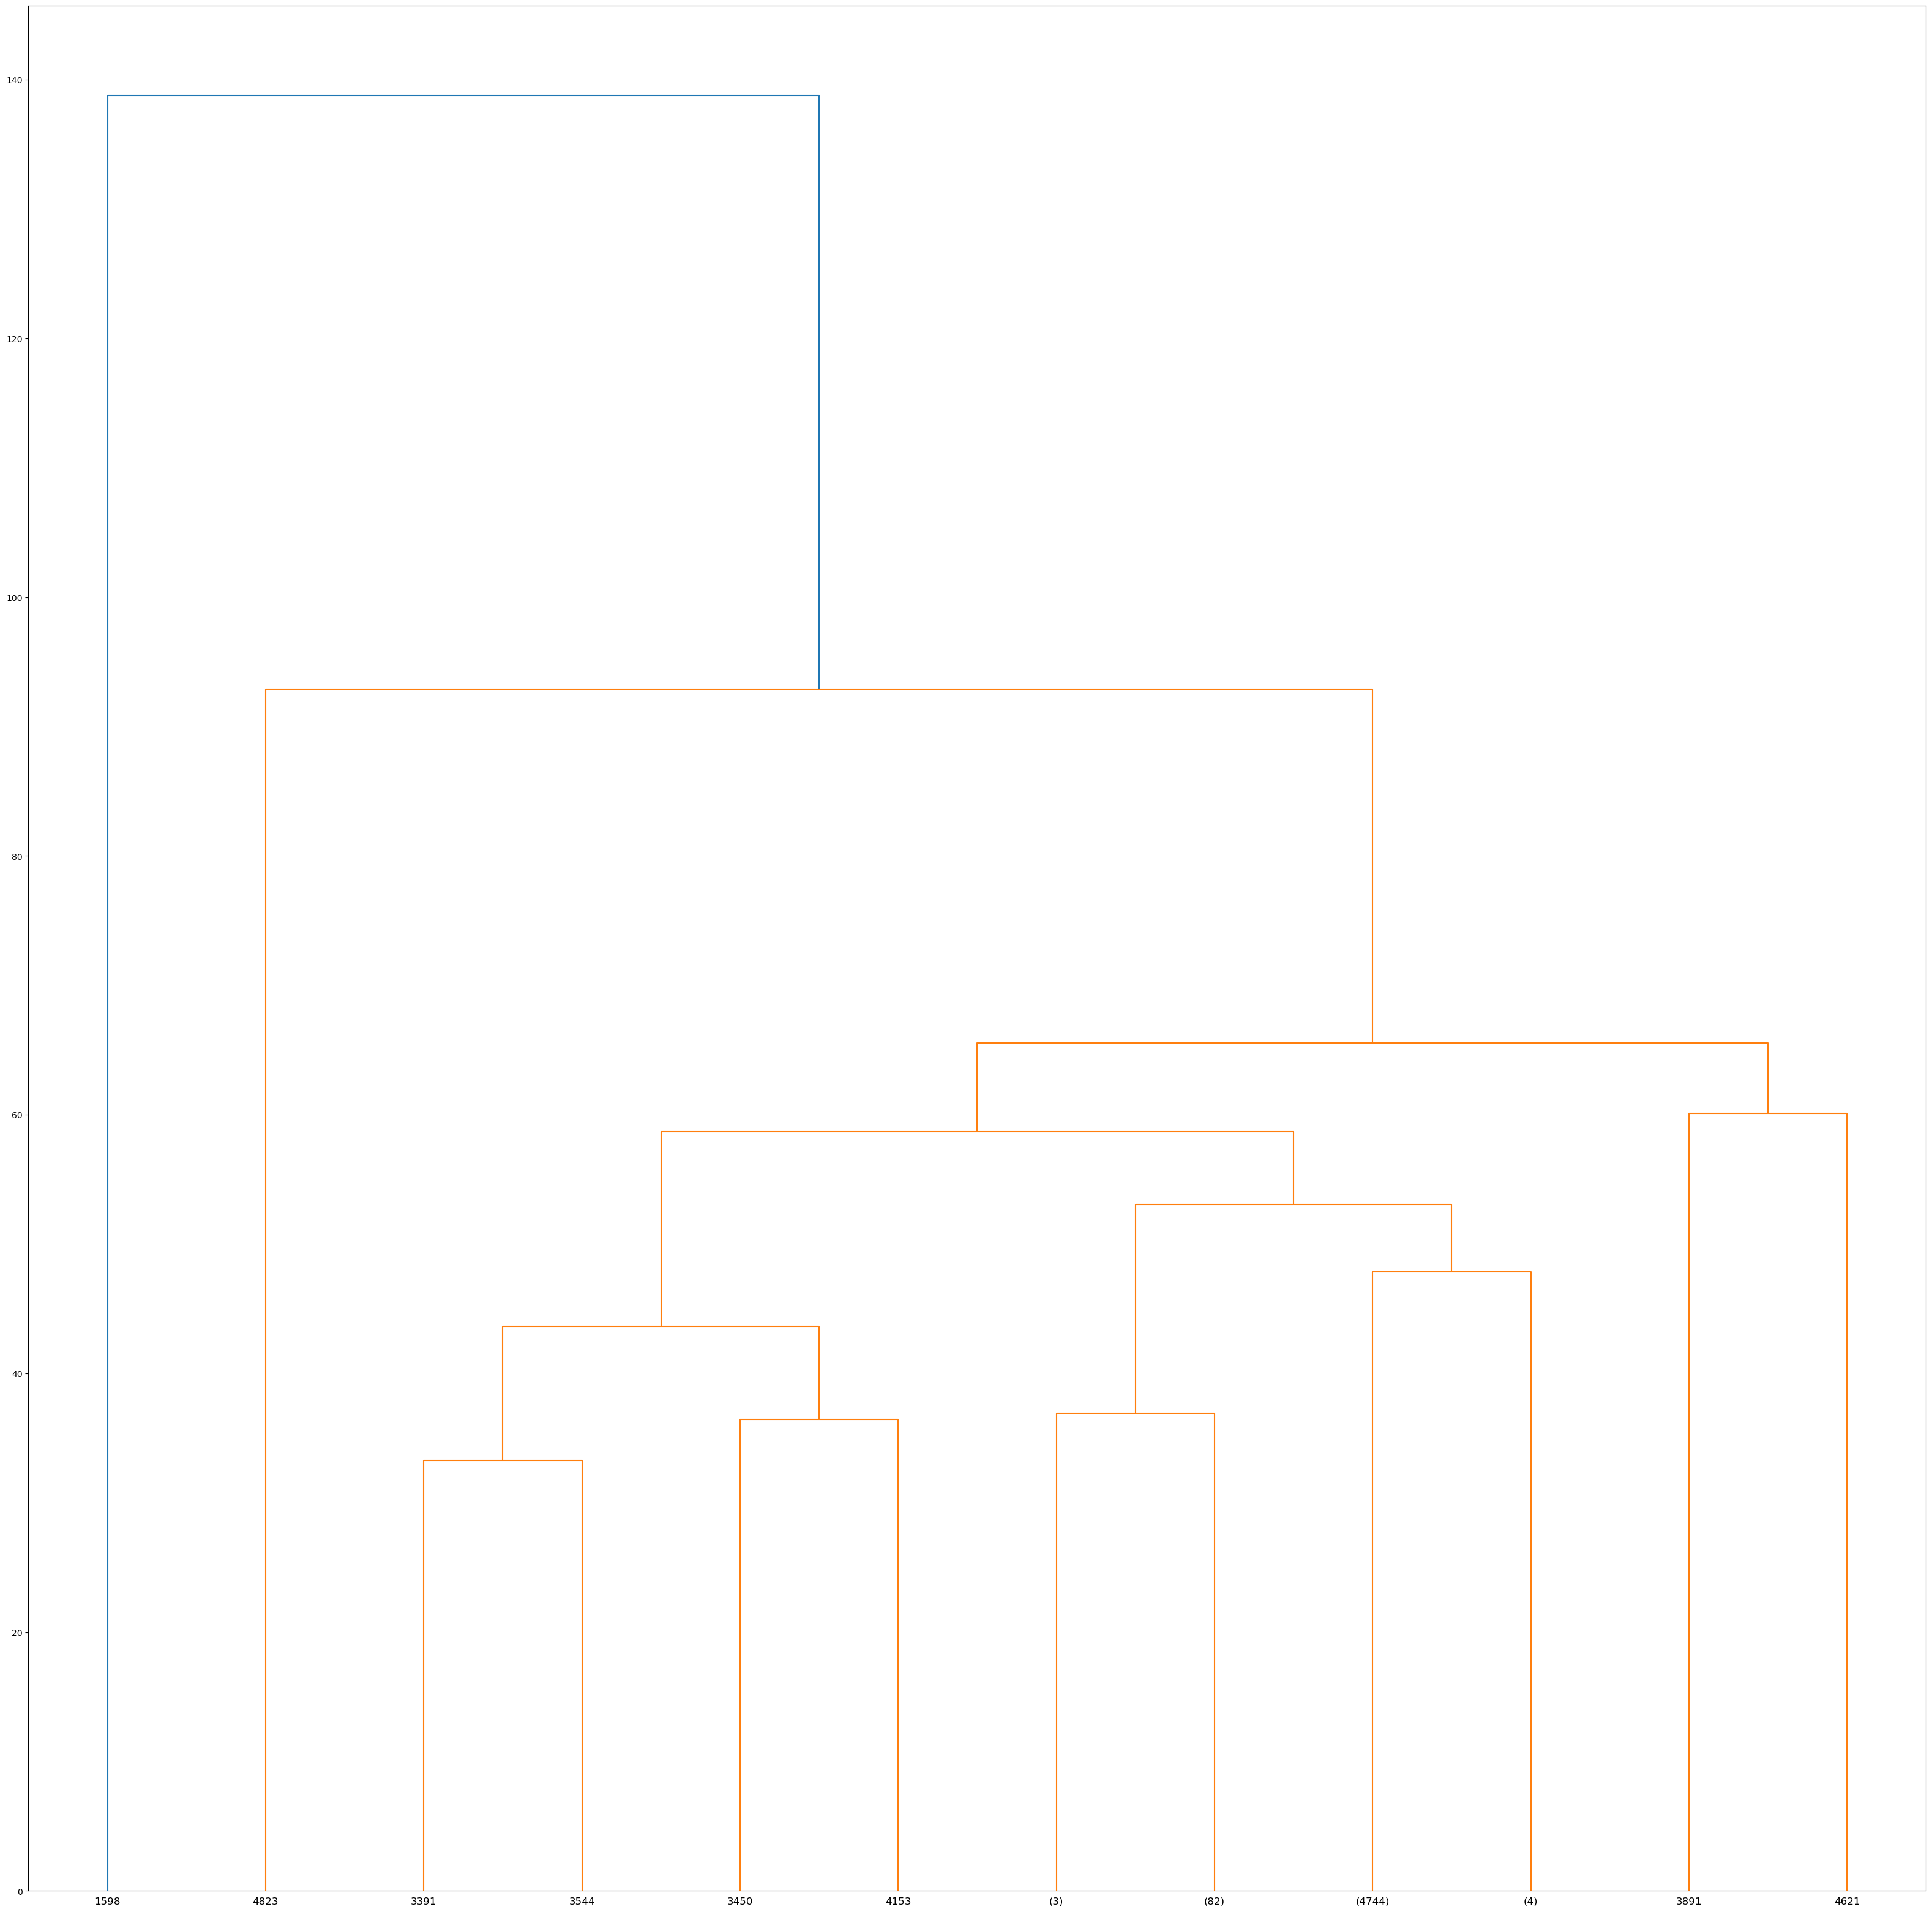

In [106]:
fix, ax = plt.subplots(figsize=(40,40))
# Plot the corresponding dendrogram
_ = dendrogram(linkage_matrix, truncate_mode="level", p=5, ax=ax)

In [107]:
from sklearn.metrics import calinski_harabasz_score

In [109]:
for t in range(1, 200, 10):
    r = fcluster(linkage_matrix, t=t, criterion='distance')
    # r = pd.Series(r, index=X_train.index)
    # # ssplits = graph.describe(r, statistics=['nunique'])['nunique']
    print(t, ' - ', 
          adjusted_rand_score(tess_groups.values, r[tess_groups_ilocs]),
          # (ssplits > 1).sum() / ssplits.shape[0],
          davies_bouldin_score(training_data, r),
          calinski_harabasz_score(training_data, r)
         )

1  -  0.00010642653992738356 0.027534678947829183 2213.3012877852334
11  -  0.1561496271647697 0.7397340557730401 33.02733700281318
21  -  0.3251670438384045 0.9774721471921197 62.986189233900284
31  -  0.004013781707679775 0.780966189280579 36.90555989764084
41  -  0.005072272167362836 0.78363872599991 80.29993931965701
51  -  0.0021995169190760213 0.5306995455762624 101.7700160103781
61  -  -0.00019873354444187866 0.5643685828672603 27.539173534837765
71  -  -5.351939626586854e-05 0.1823668808847758 33.683796623901735
81  -  -5.351939626586854e-05 0.1823668808847758 33.683796623901735
91  -  -5.351939626586854e-05 0.1823668808847758 33.683796623901735
101  -  1.935153274422666e-05 0.13596180275426278 46.70892313131309
111  -  1.935153274422666e-05 0.13596180275426278 46.70892313131309
121  -  1.935153274422666e-05 0.13596180275426278 46.70892313131309
131  -  1.935153274422666e-05 0.13596180275426278 46.70892313131309


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [112]:
clusters = fcluster(linkage_matrix, t=20, criterion='distance')

In [114]:
# plotting = tessellation.loc[training_data.index]
# plotting['label'] = clusters
# plotting.explore(column='label', categorical=True)

In [42]:
cluster_means = training_data.groupby(clusters).mean()

In [68]:
c1 = 6
c2 = 10

(cluster_means.loc[c1] - cluster_means.loc[c2]).sort_values(ascending=False)

libNCo           6.284668
libNCo_median    5.846288
libNCo_higher    4.233946
linPDE_higher    3.014914
linPDE           2.122206
                   ...   
lcnClo          -1.414220
linWID_lower    -1.422183
linP3W          -1.489277
lcnClo_lower    -1.702326
linP3W_lower    -2.339139
Length: 248, dtype: float64

In [72]:
from core.utils import used_keys
used_keys['libNCo']

'number of courtyards within adjacent buildings'